# Atividade 06

Aluno: Luiz Guilherme Seleme Fofano<br>
Disciplina: HIML<br>

## 1 - Importação

In [1]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE

In [2]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [3]:
Nc

850

(8192, 850)


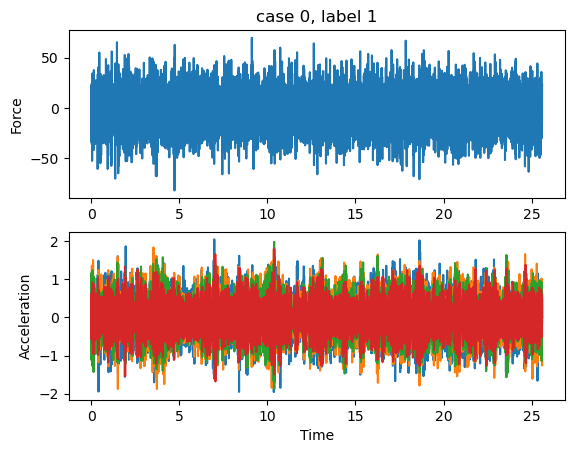

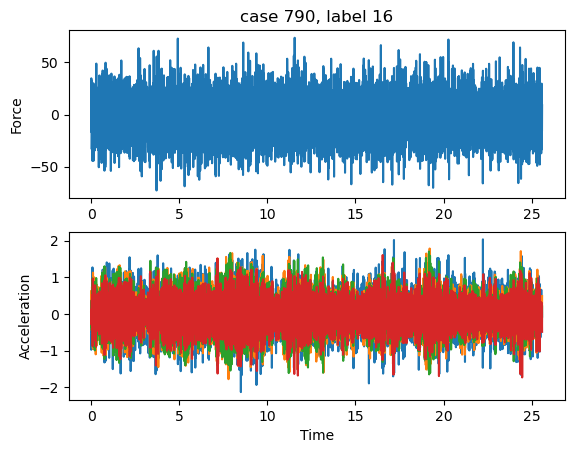

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
print(Ch1.shape)
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## 2 - AR

In [5]:
from statsmodels.tsa.ar_model import AutoReg

In [6]:
channels = [Ch2, Ch3, Ch4, Ch5]
AR = []
order = 29 # para ficar com 30 colunas por canal (n+1)

for channel in channels:
    exp = []
    for case in range(Nc):
        reg = AutoReg(channel[:,case],lags=order).fit()
        exp.append(reg.params)
    exp = np.vstack(exp)
    AR.append(exp)

X1 = np.hstack(AR)       

In [7]:
X1.shape

(850, 120)

## 3 - Preparando os Dados

Com base na atividade 2, percebeu-se que o melhor modelo em termos de predição foi o SoftMax ajustado ao conjunto X2_sc (X2 após normalização de X1), que para este caso também será normalizado.

Dessa forma, vamos dividir o conjunto X1 normalizado entre treinamento (60%) e teste (40%), fitar o PCA apenas no conjunto de treinamento, antes de transformar o conjunto inteiro, re-normalizar os conjuntos de teste e treino pós-PCA e então seguir com a atividade.

[0.37585014 0.22279748 0.10121232 0.08300921 0.05197382 0.03813015
 0.03673931 0.02504004 0.01399312 0.01232693]


São necessários 10 componentes para atingir uma variância explicada de 0.9610725174870596 (>95%)


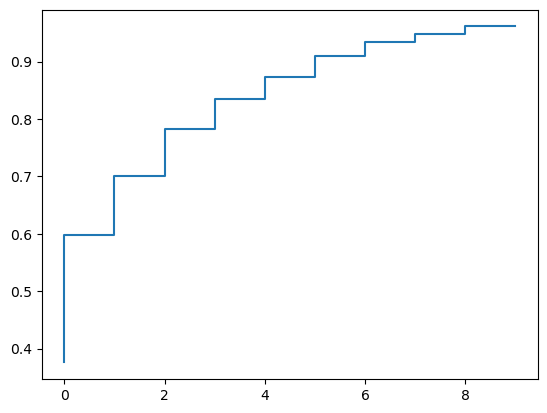

In [8]:
# Normalização
rand = 1009

scaler = MinMaxScaler(feature_range=(-1,1))
X1_sc = scaler.fit(X1).transform(X1)


# Divisão em grupo de treinamento e teste

X1_tr, X1_te, y_tr, y_te = train_test_split(X1_sc, y,random_state=rand,test_size=0.4)


# Aplicação do PCA e re-normalização

pca = PCA(n_components = 0.95)
pca.fit(X1_tr)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
print(exp_var)
plt.step(range(0,len(cum_var)),cum_var,label='Cumulative variance')
print(f'\n\nSão necessários {len(exp_var)} componentes para atingir uma variância explicada de {cum_var[-1]} (>95%)')

X1_tr_pca = pca.transform(X1_tr)
X1_te_pca = pca.transform(X1_te)

X1_tr_pca_norm = scaler.fit(X1_tr_pca).transform(X1_tr_pca)
X1_te_pca_norm = scaler.fit(X1_tr_pca).transform(X1_te_pca)


## 4 - Utilização do KMeans

In [9]:
kmeans = KMeans(n_clusters=17, random_state=rand)

y_kmean = kmeans.fit_predict(X1_tr_pca_norm)
y_kmean, y_tr

(array([ 1,  0,  1,  5, 11,  0, 15,  4, 10, 15,  7, 15,  0,  5, 15,  7, 10,
         1, 12,  2,  8, 11,  8, 13,  3, 12,  9,  0,  4,  8,  3, 10,  0,  4,
         3,  8,  9, 14, 13, 16,  0, 16, 11,  0, 12,  9,  2, 11, 12, 12, 12,
         6,  8,  0, 10,  6, 15, 11,  6,  0,  8, 15,  6,  6,  2,  0,  1, 12,
        15, 10,  9,  2, 12,  6, 12,  1, 15, 10,  4,  9,  1,  0, 10,  0,  1,
        16, 14,  2, 12,  8, 11, 14,  2, 16, 15,  3,  1,  3, 13,  7,  3, 16,
         5,  9, 14,  6,  8, 13,  5, 13, 16,  0, 10, 14,  1,  8, 11,  9,  3,
         5,  2, 16,  3,  8, 11, 11,  9, 11, 11,  8,  3,  9, 11,  5,  9,  1,
         0, 10,  1,  9,  6,  3, 10,  8, 13, 11,  3, 16, 13, 13,  6,  8,  4,
        16, 11,  8,  6, 14,  1,  4, 12,  0, 16, 10,  5,  1, 14,  6,  7, 13,
        14,  8,  5,  3,  3,  5,  8, 12,  3,  2, 15,  1, 13, 13, 15, 10,  7,
         3,  5,  9,  5, 10,  7, 14,  8,  9,  7, 11,  2,  6, 12, 11,  4,  7,
         9,  6, 16, 12, 10, 12, 10, 11, 12,  5,  9,  5,  3, 15,  5,  6, 12,
         3, 

In [10]:
# Ajustando a numeração dos clusters
corretor = []

for i in range(len(np.unique(y_tr))):
    corretor.append(i)
    
for classe in range(len(np.unique(y_tr))):
    cont_class = []
    for i in range(len(y_tr)):
        if y_tr[i] == classe + 1:
            cont_class.append(y_kmean[i])
    moda = stats.mode(cont_class)[0][0]
    corretor[moda] = classe + 1
    
print(corretor)

def ajusta_cluster(x,moda):
    for i in range(len(x)):
        x[i] = moda[x[i]]
    return(x)
                   
y_kmean_ajuste = ajusta_cluster(y_kmean,corretor)

y_tr, y_kmean_ajuste

[6, 4, 11, 13, 8, 10, 1, 12, 5, 17, 9, 15, 7, 16, 3, 14, 2]


C:\Users\c5ex\AppData\Local\Temp\ipykernel_24368\4095630996.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  moda = stats.mode(cont_class)[0][0]


(array([ 4,  6,  4, 10, 15,  6, 14,  8,  9, 14, 12, 14,  6, 10, 14, 12,  9,
         4,  7, 11,  5, 10,  5, 16, 13,  7, 17,  6,  8,  5, 13,  9,  6,  8,
        13,  5, 17,  3, 16,  2,  6,  2, 15,  6,  7, 17, 11, 10,  7,  7,  7,
         1,  5,  6,  9,  1, 14, 15,  1,  6,  5, 14,  1,  1, 11,  6,  4,  7,
        14,  9, 17, 11,  7,  1,  7,  4, 14,  9,  8, 17,  4,  6,  9,  6,  4,
         2,  3, 11,  7,  5, 10,  3, 11,  2, 14, 13,  4, 13, 16, 12, 13,  2,
        10, 17,  3,  1,  5, 16, 15, 16,  2,  6,  9,  3,  4,  5, 15, 17, 13,
        10, 11,  2, 13,  5, 15, 15, 17, 10, 10,  5, 13, 17, 15, 10, 17,  4,
         6,  9,  4, 17,  1, 13,  9,  5, 16, 15, 13,  2, 16, 16,  1,  5,  8,
         2, 15,  5,  1,  3,  4,  8,  7,  6,  2,  9, 15,  4,  3,  1, 12, 16,
         3,  5, 10, 12, 13, 10,  5,  7, 13, 11, 14,  4, 16, 16, 14,  9, 12,
        13, 10, 17, 10,  9, 12,  3,  5, 17, 12, 15, 12,  1,  7, 15,  8, 12,
        17,  1,  2,  7,  9,  7,  9, 10,  7, 10, 17, 10, 13, 13, 15,  1,  7,
        13, 


A qualidade de ajuste do KMeans foi de 0.9450980392156862



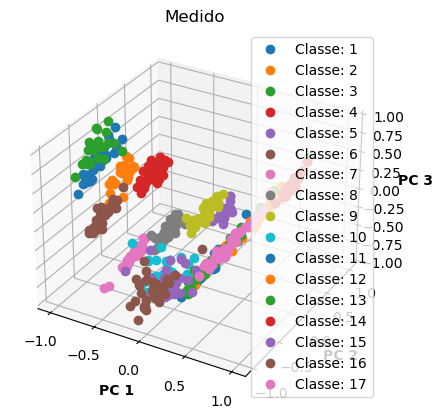

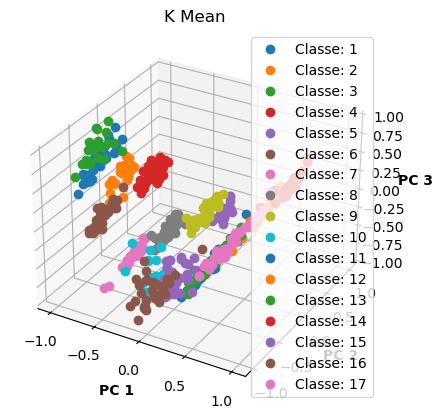

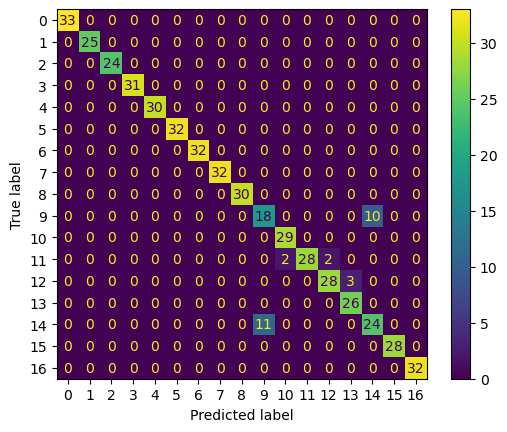

In [11]:
#qualidade do ajuste e plot 3D
cont_OK = 0
cont_total = 0

for i in range(len(y_tr)):
    if y_tr[i] == y_kmean_ajuste[i]:
        cont_OK = cont_OK + 1
    cont_total = cont_total+1
    
print(f'\nA qualidade de ajuste do KMeans foi de {cont_OK/cont_total}\n')



fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in np.unique(y_tr):
    X1_tr_plot = X1_tr_pca_norm[y_tr == i]
    ax.plot3D(X1_tr_plot[:,0], X1_tr_plot[:,1], X1_tr_plot[:,2], 'o', label='Classe: {}'.format(i))
    
ax.set_title("Medido")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')
ax.legend()

fig2 = plt.figure()
ax2 = plt.axes(projection ='3d')
for i in np.unique(y_tr):
    X1_tr_plot = X1_tr_pca_norm[y_kmean_ajuste == i]
    ax2.plot3D(X1_tr_plot[:,0], X1_tr_plot[:,1], X1_tr_plot[:,2], 'o', label='Classe: {}'.format(i))
    
ax2.set_title("K Mean")
ax2.set_xlabel('PC 1', fontweight ='bold')
ax2.set_ylabel('PC 2', fontweight ='bold')
ax2.set_zlabel('PC 3', fontweight ='bold')
ax2.legend()




# Plotando a matriz de confusao
cm_test = confusion_matrix(y_tr, y_kmean_ajuste)
ConfusionMatrixDisplay(cm_test).plot()


## 5 - Visualizando com t-SNE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


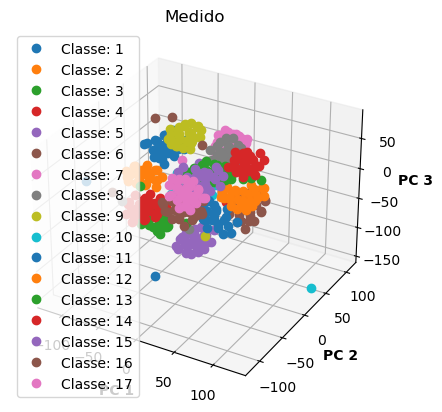

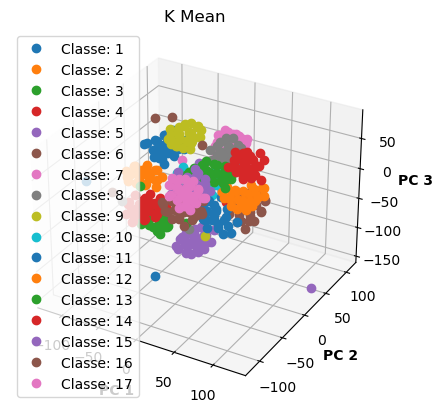

In [12]:
tsne = TSNE(n_components=3)

X1_tr_tsne = tsne.fit_transform(X1_tr_pca_norm)

fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in np.unique(y_tr):
    X1_tr_plot = X1_tr_tsne[y_tr == i]
    ax.plot3D(X1_tr_plot[:,0], X1_tr_plot[:,1], X1_tr_plot[:,2], 'o', label='Classe: {}'.format(i))
    
ax.set_title("Medido")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')
ax.legend()

fig2 = plt.figure()
ax2 = plt.axes(projection ='3d')
for i in np.unique(y_tr):
    X1_tr_plot = X1_tr_tsne[y_kmean_ajuste == i]
    ax2.plot3D(X1_tr_plot[:,0], X1_tr_plot[:,1], X1_tr_plot[:,2], 'o', label='Classe: {}'.format(i))
    
ax2.set_title("K Mean")
ax2.set_xlabel('PC 1', fontweight ='bold')
ax2.set_ylabel('PC 2', fontweight ='bold')
ax2.set_zlabel('PC 3', fontweight ='bold')
ax2.legend()

## 6 - OneClass SVM

Text(0.5, 0, 'PC 3')

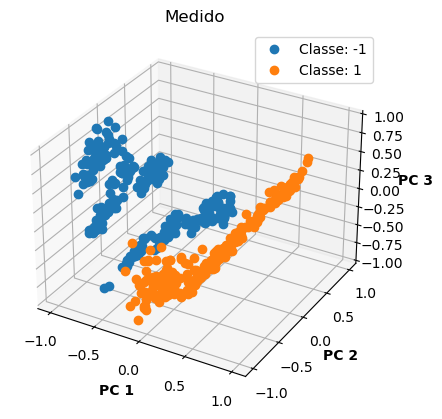

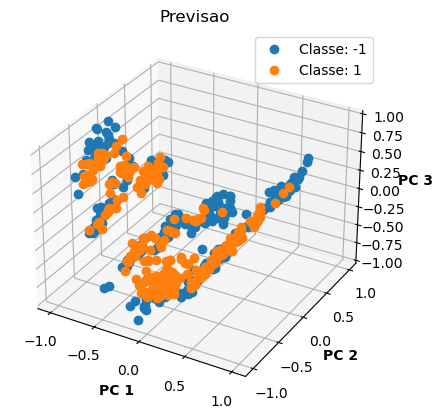

In [13]:
# Ajuste considerando OneClass SVM Default
X1_ocsvm = OneClassSVM().fit(X1_tr_pca_norm)

y_ocsvm = X1_ocsvm.predict(X1_tr_pca_norm)


y_falha = []
for i in range(len(y_tr)):
    if y_tr[i] <= 9:
        y_falha.append(-1)
    else:
        y_falha.append(1)

fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in np.unique(y_falha):
    X1_tr_plot = X1_tr_pca_norm[y_falha == i]
    ax.plot3D(X1_tr_plot[:,0], X1_tr_plot[:,1], X1_tr_plot[:,2], 'o', label='Classe: {}'.format(i))
ax.legend()

ax.set_title("Medido")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')


fig2 = plt.figure()
ax2 = plt.axes(projection ='3d')
for i in np.unique(y_ocsvm):
    X1_tr_plot = X1_tr_pca_norm[y_ocsvm == i]
    ax2.plot3D(X1_tr_plot[:,0], X1_tr_plot[:,1], X1_tr_plot[:,2], 'o', label='Classe: {}'.format(i))
ax2.legend()

ax2.set_title("Previsao")
ax2.set_xlabel('PC 1', fontweight ='bold')
ax2.set_ylabel('PC 2', fontweight ='bold')
ax2.set_zlabel('PC 3', fontweight ='bold')



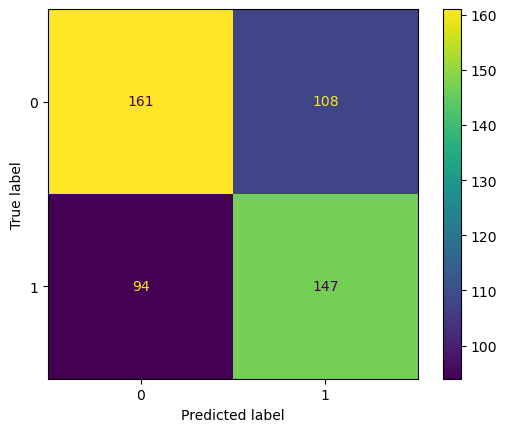

In [14]:
#plotando matriz de confusão

cm = confusion_matrix(y_falha, y_ocsvm)
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
cmgraph.plot(ax=ax)

## 7 - Conclusões

Pode-se perceber que o KMeans tem uma boa qualidade de representação dos grupos, chegando em 94% de "acurácia". OS erros também ficaram localizados no mesmo quadrante binário dos dados originais, o que traz maior confiabildiade ao resultado.

A utilização do t-SNE facilita enormemente a visualização de dados em espaçoes multi-dimensionais.

A aplicação do OneClass SVM não se mostrou adequada para calssificação do conjunto de dados em questão, ao menos na sua configuração default.